# Predicting IBD risk from genomic data using machine learning

Author: [Samit Watve](#https://www.linkedin.com/in/samitwatve/) 
    
This project was developed as a capstone project for [BrainStation](https://brainstation.io/)'s Data Science Bootcamp which was conducted virtually from September 28th - December 18th 2020. The goal of this project was to create a machine learning model / pipeline, that is capable of predicting whether a test subject has Inflammatory Bowel Disease (IBD) or will develop IBD in the future **solely** using genomic data (i.e. SNP data).

Load in some data science packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
import collections
from collections import Counter

The data we care about is contained in two csv files, the `Genotypes` file and the `Patients` file.

Load in first file containing the genotypes data into a dataframe.

**WARNING:** 

This is a fairly large file `~5 GB`, so will take some time to load. In some cases you might have to adjust the page file size to avoid memory errors (I did so on my windows machine using the instructions given here, and that fixed my memory errors https://www.tomshardware.com/news/how-to-manage-virtual-memory-pagefile-windows-10,36929.html)

In [2]:
#Read in the genotpes csv
genotypes = pd.read_csv("data\Combined_2645_Samples_Genotypes.csv", sep="\t")

#view the dataframe
genotypes.head()

,snp,chr,pos,6198863118_R01C01,8647968039_R01C02,6198863118_R02C01,6198863118_R03C01,8647968039_R02C02,8647968039_R03C02,8647968024_R01C02,...,7384449012_R05C01,7382902015_R05C02,7384449023_R01C01,7384449023_R06C01,7384449023_R04C01,7384449023_R03C01,7382902007_R04C02,7382902005_R06C01,7382902017_R06C01,7382902015_R06C01
0,seq-rs1790315,11,70780791,AA,AA,AG,AA,GG,AA,AA,...,AG,AG,AG,AG,AA,AG,AA,AG,AG,AA
1,imm_1_7684595,1,7684595,GG,GG,GG,GG,GG,GG,GG,...,GG,GG,GG,GG,GG,GG,GG,GG,GG,GG
2,1kg_1_67617298,1,67617298,AG,AG,AG,AG,AG,AG,AG,...,AG,--,AG,AG,AG,AG,--,--,--,--
3,rs3777768,6,12255600,CG,GG,GG,GG,CG,CG,CG,...,GG,CG,CG,GG,GG,CG,CG,CG,GG,CC
4,1kg_1_159802959,1,159802959,AG,AG,AG,AG,AG,AG,AG,...,AG,--,AG,AG,AG,AG,AG,AG,AG,AG


In [3]:
genotypes.shape

(196523, 2648)

We have 196523 genomic features aka SNP's in our dataframe and 2645 patients and 3 columns for SNP ID, chromosome number and chromosome position

In [4]:
#Collects all the snp id's, chromosomes and genomic positions into individual lists
snp_list = genotypes['snp']
chr_list = genotypes['chr']
pos_list = genotypes['pos']
print(len(snp_list), len(chr_list), len(pos_list))

196523 196523 196523


For machine learning we want our data to be in a wide matrix format where the SNP's are represented as columns and patients as rows, so i will transpose the data frame

In [5]:
#Transpose the genotypes dataframe and save it as transpose_df with snp_list as column names
transpose_df = genotypes.set_index(snp_list).T
transpose_df.reset_index()
transpose_df.head()

snp,seq-rs1790315,imm_1_7684595,1kg_1_67617298,rs3777768,1kg_1_159802959,rs7299872,imm_5_131554635,rs35796161,seq-VH-2915,imm_13_43155437,...,imm_17_35321569,imm_1_196009571,imm_1_199241511,rs13188874,rs17386441,rs6838929,imm_22_37997122,imm_14_97465990,rs9541052,seq-rs1339131
snp,seq-rs1790315,imm_1_7684595,1kg_1_67617298,rs3777768,1kg_1_159802959,rs7299872,imm_5_131554635,rs35796161,seq-VH-2915,imm_13_43155437,...,imm_17_35321569,imm_1_196009571,imm_1_199241511,rs13188874,rs17386441,rs6838929,imm_22_37997122,imm_14_97465990,rs9541052,seq-rs1339131
chr,11,1,1,6,1,12,5,6,4,13,...,17,1,1,5,1,4,22,14,13,1
pos,70780791,7684595,67617298,12255600,159802959,55233823,131554635,112058638,123608871,43155437,...,35321569,196009571,199241511,129698191,98818587,37632992,37997122,97465990,67855709,190556589
6198863118_R01C01,AA,GG,AG,CG,AG,AA,AA,AC,CC,GG,...,AA,AG,--,AT,AA,GG,GG,AA,GG,GG
8647968039_R01C02,AA,GG,AG,GG,AG,AG,AA,CC,CC,GG,...,AG,AA,AG,AT,AA,GG,GG,AA,AG,GG


The data is now oriented the way we need. 

Each **row** represents a single individual / patient. The same individual id's are also listed in the patients file which we will look at later.

Each **column** represents a single position on the genome. 

For example the snp "seq-rs1790315" refers to chromosome 11 and position 70780791 of the human genome.
The patient identified by id# 6198863118_R01C01 has two alleles one inherited from the mother and another from the father. In this case both alleles at this position are `A`/`A`.  

This information can be cross-referenced with a public database called dbSNP.
https://www.ncbi.nlm.nih.gov/snp/rs1790315#frequency_tab. 

From the dbSNP page, we can see that the major allele (sometimes called the reference allele) at this location is `A` while the alternate allele at this location is a `G`. Therefore, some individuals might have a genotype `AA` for this location, others will have `AG` (example patient id#6198863118_R02C01: AG) and a few might have `GG` (example patient id#8647968039_R02C02: GG)

We can also see that the major allele (or reference allele) can be different in different human populations. For example, according to the [1000 genomes](https://www.ncbi.nlm.nih.gov/bioproject/PRJEB6930) project, in the `global` population, the frequency of allele `A` is only `0.49`, but in the `european` population, the frequency of allele `A` is `0.70`. So depending on the population the samples come from, the major allele / minor allele designations may be different. The original study looked at samples from the `european` population only.

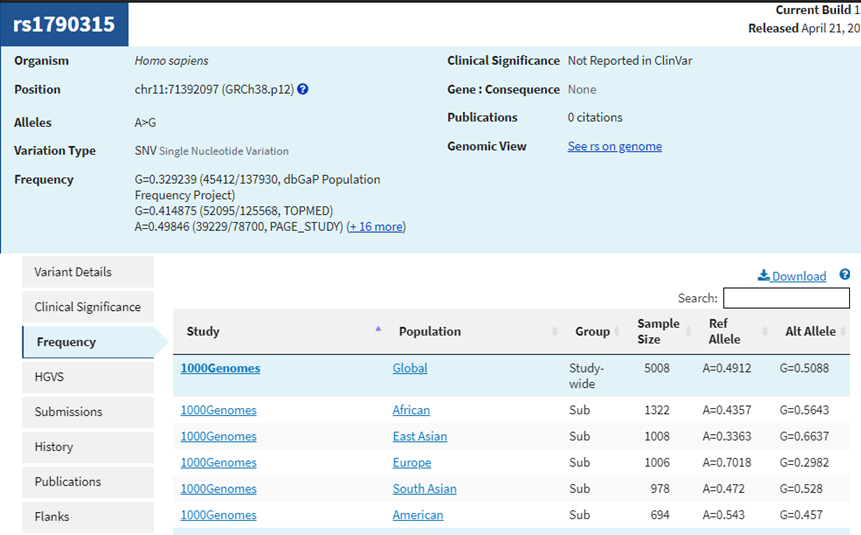



**I will be performing my own major / minor allele calculations later and will NOT be relying on the dbSNP designations for this project.**

For the initial data exploration, we dont need the rows containing the SNP ID's, chromosome location and chromosome position, so i will drop these rows.

In [6]:
#drop the snp's, chromosomes and the positions rows.
transpose_df.drop(transpose_df.index[[0,1,2]], inplace=True)
transpose_df.index.name = "Indiv_ID"
transpose_df.head()

snp,seq-rs1790315,imm_1_7684595,1kg_1_67617298,rs3777768,1kg_1_159802959,rs7299872,imm_5_131554635,rs35796161,seq-VH-2915,imm_13_43155437,...,imm_17_35321569,imm_1_196009571,imm_1_199241511,rs13188874,rs17386441,rs6838929,imm_22_37997122,imm_14_97465990,rs9541052,seq-rs1339131
Indiv_ID,,,,,,,,,,,,,,,,,,,,,
6198863118_R01C01,AA,GG,AG,CG,AG,AA,AA,AC,CC,GG,...,AA,AG,--,AT,AA,GG,GG,AA,GG,GG
8647968039_R01C02,AA,GG,AG,GG,AG,AG,AA,CC,CC,GG,...,AG,AA,AG,AT,AA,GG,GG,AA,AG,GG
6198863118_R02C01,AG,GG,AG,GG,AG,GG,AA,AA,CC,GG,...,AG,AA,--,TT,AA,AG,GG,AA,AG,GG
6198863118_R03C01,AA,GG,AG,GG,AG,AG,AA,AA,CC,GG,...,GG,AA,--,TT,AG,AG,GG,AA,GG,GG
8647968039_R02C02,GG,GG,AG,CG,AG,AG,AA,AA,CC,GG,...,AA,AA,--,TT,AA,GG,GG,AA,GG,AG


**Data exploration**

Let's try see the distribution of SNP value counts for the first few SNPs. 

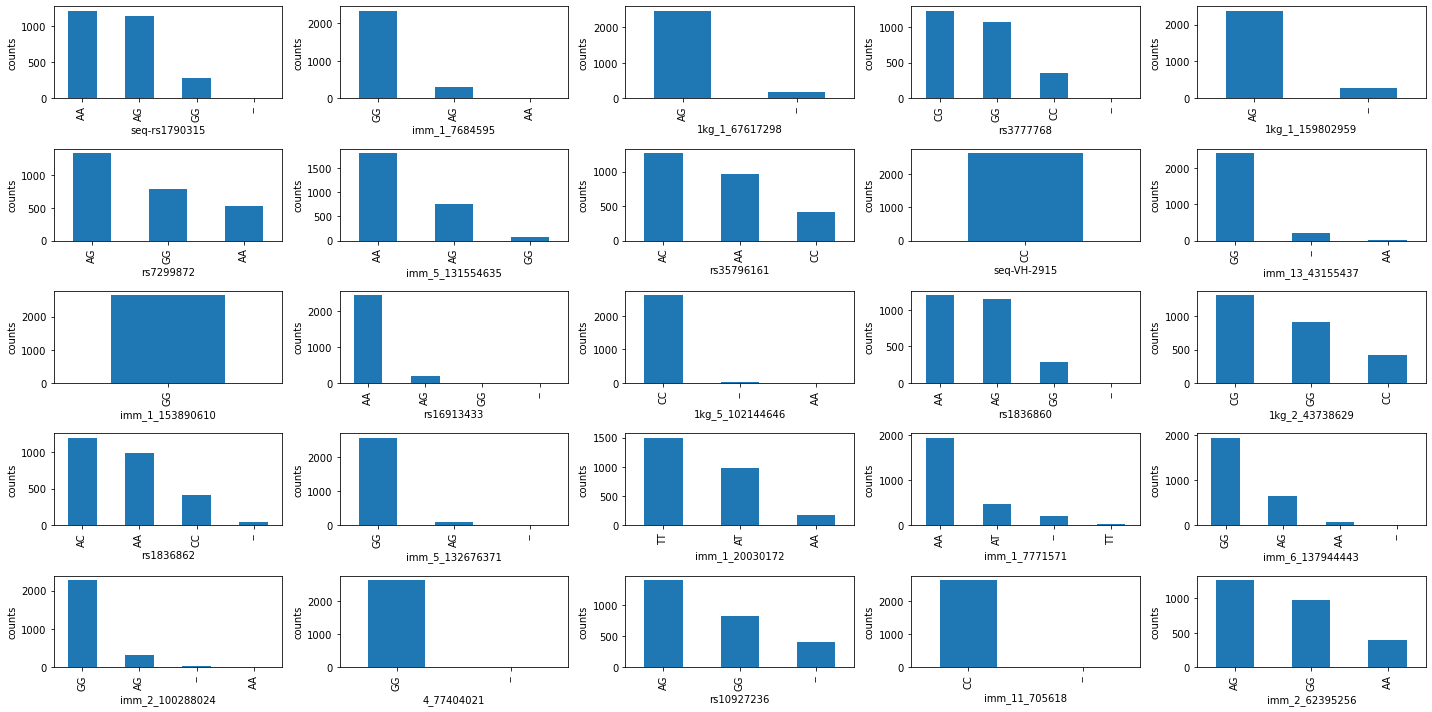

In [7]:
#Setup the subplots object
plt.subplots(5,5, figsize = (20,10))

#Create a counter
counter = 0

#loop over the first few columns in the data frame
for column in transpose_df.columns[0:25]:
    
    #increment counter
    counter+=1
    
    #plot the first subplot
    plt.subplot(5,5,counter)
    
    #label axes
    plt.xlabel(column)
    plt.ylabel("counts")
    
    #plot the value counts
    transpose_df[column].value_counts().plot(kind='bar')

#Cleanly display the figure
plt.tight_layout()

#Show the figure
plt.show()

**Observations:**
    
By looking at the distribution of value counts of the first 3 SNP locations, we notice a few things.

1) The number of SNP values range from 1 - 4 at each genomic location. 

2) A few SNP columns have missing data "-"

3) In most cases a large proportion of value counts are dominated by either 1 or 2 `biallelic SNP values` e.g. for the snp "seq-rs1790315",
`AA` and `AG` capture a large proportion of cases. This is because the major allele is 'A' and the minor allele is 'G'. So the combination `AA` occurs most frequently, followed by `AG` followed by `GG` in a small number of cases.

Let's see how many different SNP values we have in our entire dataframe

In [8]:
#Collecting all the unique items in the entire dataframe
unique_items = []
for i in tqdm(transpose_df.columns):
    for item in transpose_df[i].unique():
        if item not in unique_items:
            unique_items.append(item)
print(unique_items)
print(len(unique_items))

100%|████████████████████████████████████████████████████████████████████████| 196523/196523 [01:03<00:00, 3076.26it/s]

['AA', 'AG', 'GG', '--', 'CG', 'CC', 'AC', 'TT', 'AT', 'DD', 'ID', 'II', 'DI']
13


**Observations:**
    
Across the entire dataframe there are only 13 possible SNP values:

['AA', 'GG', 'AG', 'CG', 'AC', 'CC', 'TT', '--', 'DD', 'II', 'DI', 'AT', 'ID']

['AA', 'GG', 'AG', 'CG', 'AC', 'CC', 'TT', 'AT']: These are the observed SNP's

['II', 'ID', 'DD', 'DI']: Refer to insertion / insertion, insertion / deletion, deletion / deletion or deletion / insertion respectively. While these can often be linked to disease phenotypes, they are tricky to interpret since all patients may not share the same insertion or deletion. For example, patient 1 might have an insertion of 2 bases while patient 2 might have an insertion of 10 bases and both would be called as `I`. Similarly patient 1 might have a deletion where 2 bases are missing while another might have a deletion with 6 bases mising. 

**For this project I will be dropping these value types later.**

['--'] refers to missing values

**Data cleaning**

Cleaning steps:

For our purposes, we need to get rid of `missing data`, `low information data` or `non-informative data` such as insertions and deletions. This will help in two ways - 
1) This helps reduce the size of the datasets (and lead to faster run-time) 

2) We are only interested in those features that have `maximum discriminatory power` between the healthy or the diseased class. 

Therefore, I will drop SNP columns where:
- Step 1) The amount of missing data i.e. `--` values are `more than 5%` of the data in the column

then drop columns with,

- Step 2) Only `a single biallelic value` is present (e.g. `CC` or `AG` in all patients)

The logic here is that if all individuals have the same SNP at a particular position, but only some of them have the disease, then that SNP is unlikely to be associated with the disease.

then drop columns with,

- Step 3) Only 2 types of values, `biallelic data and missing data` (e.g. `GG in 97% of patients and -- in the remaining 3%`) this situation is almost identical to situation 2) but the missing data in that column allows it to pass that particular filter.

and then drop those columns,

- Step 4) Containing exclusively indel data i.e. `II, ID, DI, DD or --` in the snp value fields

In [9]:
#Create 4 empty lists, one for each situation
situ_1, situ_2, situ_3, situ_4 = [], [], [], []

#loop over each column and check if any of the 4 situations listed above apply to that column
for i in tqdm(transpose_df.columns):
    #Check if Situation 1 applies
    if (transpose_df[i] == "--").sum() / len((transpose_df[i] == "--")) > 0.05:
        #add column name to the list if it does
        situ_1.append(i)
    
    #Check if Situation 2 applies
    elif transpose_df[i].nunique() == 1:
        #add column name to the list if it does
        situ_2.append(i)
    
    #Check if Situation 3 applies
    elif(transpose_df[i].nunique() == 2) & ("--" in transpose_df[i].unique()):
        #add column name to the list if it does
        situ_3.append(i)
        
    #Check if Situation 4 applies
    elif any(k in transpose_df[i].unique() for k in ['AA', 'GG', 'AG', 'CG', 'AC', 'CC', 'TT', 'AT']) == False:
        #add column name to the list if it does
        situ_4.append(i)
        
#print out the length of each list
print(f'# of situ_1 columns: {len(situ_1)}')
print(f'# of situ_2 columns: {len(situ_2)}')
print(f'# of situ_3 columns: {len(situ_3)}')
print(f'# of situ_4 columns: {len(situ_4)}')

100%|█████████████████████████████████████████████████████████████████████████| 196523/196523 [05:55<00:00, 552.63it/s]

# of situ_1 columns: 14061
# of situ_2 columns: 7614
# of situ_3 columns: 19865
# of situ_4 columns: 460


Since we want to drop all these columns, let's collect them in a single list

In [10]:
#Collect all columns into a single list
drop_cols_list = np.unique(np.array(situ_1 + situ_2 + situ_3 + situ_4))
print(len(drop_cols_list))

42000


That's a big reduction in our dataset with 42000 columns to be dropped!

In [11]:
#Drop those columns inplace
transpose_df.drop(drop_cols_list, inplace = True, axis = 'columns')
print(transpose_df.shape)

(2645, 154523)


Step 5) Filtering based on `Minor Allele Frequency (MAF) < 0.02`

The most common allele in the population in called the major allele and the second most common is the minor allele. Shown here is a hypothetical example of allele counts at a given genome position.

|Allele|Totals|Allele frequency|Type|
|------|-------|--------|------|
|A|**5000**|5000/ 5820 = 0.86|Major Allele|
|G|**820**|820 / 5820 = 0.14|Minor Allele|

Recall that each biallelic SNP, e.g. AG contains one paternal (viz. 'A') and one maternal allele (viz. 'G'). To estimate allele frequencies, we will sum the occurance of each indiviudal allele across the population for that specific SNP location. Thus all A's and G's in this particular column will be summed up and expressed as a fraction of the total number of single alleles (see table)

In this case, `A` is the major allele and has an allelic frequency of 0.86 and `G` is the minor allele with an allelic frequency of 0.14. We want the minor allele to be at a frequency of atleast 0.02. Otherwise, it means that the major allele is so prevalent that there is essentially only one allele in the population and therefore this particular SNP location does not have a good association with either the healthy or the diseased class.

In [12]:
#Create empty lists for columns, major and minor alleles, counts of major and minor alleles and columns with maf<0.02
all_cols, maj_allele, maj_allele_counts, min_allele, min_allele_counts, maf_cols = [], [], [], [], [], []

#Loop over all columns in the dataframe
for i in tqdm(transpose_df.columns):
    
    #First create an empty string
    my_string = ""
    
    #For each SNP pair in a column
    for snp_pairs in transpose_df[i]:
        #add the snp pair to the list
        my_string = my_string + str(snp_pairs)
    
    #Use the Counter function to count the occurences of each character i.e. allele in the SNP column
    #The counts are returned as a dictionary that looks like this {"A": 3200, "G": 1452, "--":5}
    counts=Counter(my_string) 
    
    #We sort the dictionary to arrange the values in descending order
    sorted_x = sorted(counts.items(), key=lambda kv: kv[1], reverse = True)
    sorted_dict = collections.OrderedDict(sorted_x)
    
    #Then we pull out the most common SNP
    maj_allele.append(list(sorted_dict.keys())[0])
    
    #Pull out the frequency of the most common SNP
    maj_allele_counts.append(list(sorted_dict.values())[0])
    
    #Pull out the second common SNP
    min_allele.append(list(sorted_dict.keys())[1])
    
    #Pull out the frequency of the second common SNP
    min_allele_counts.append(list(sorted_dict.values())[1])
    
    #Collect all the columns in a list
    all_cols.append(i)      

    #Calculate the Minor allelele frequency (MAF)
    MAF = list(sorted_dict.values())[1] / (list(sorted_dict.values())[1] + list(sorted_dict.values())[0])
    if MAF < 0.02:
        #Collect the low frequency ones
        maf_cols.append(i)
        
#See the lengths of all these collumns
print(len(maf_cols))      
print(len(all_cols))
print(len(maj_allele))
print(len(min_allele))
print(len(maj_allele_counts))
print(len(min_allele_counts))

100%|█████████████████████████████████████████████████████████████████████████| 154523/154523 [05:54<00:00, 435.71it/s]

25910
154523
154523
154523
154523
154523


There are 25910 columns that have MAF < 0.02 that we will drop

In [13]:
#Drop the "maf_cols" i.e. the ones with MAF < 0.02
transpose_df.drop(maf_cols, inplace = True, axis = 'columns')
print(transpose_df.shape)

(2645, 128613)


Store the remaining information into a single dataframe called `allele_df`

In [14]:
#We will store the remaining info into a single df called allele df
allele_df = pd.DataFrame([maj_allele, maj_allele_counts, min_allele, min_allele_counts], columns = all_cols)

#Then drop the low MAF ones from allele_df
allele_df.drop(maf_cols, inplace = True, axis = 'columns')

#View the dataframe
allele_df.head()

,seq-rs1790315,imm_1_7684595,rs3777768,rs7299872,imm_5_131554635,rs35796161,rs16913433,rs1836860,1kg_2_43738629,rs1836862,...,rs6588810,1kg_14_34546424,imm_9_138301427,imm_17_35321569,imm_1_196009571,rs13188874,rs17386441,imm_22_37997122,rs9541052,seq-rs1339131
0,A,G,G,G,A,A,A,A,G,A,...,G,A,T,A,A,T,A,G,G,G
1,3573,4964,3350,2896,4372,3190,5065,3552,3145,3177,...,4555,4321,4548,2694,4748,4418,4624,5131,4444,2992
2,G,A,C,A,G,C,G,G,C,C,...,A,G,A,G,G,A,G,A,A,A
3,1709,326,1932,2394,918,2100,219,1736,2145,2027,...,657,817,722,2588,542,870,666,141,840,2298


Step 6) Filtering out columns where missing data i.e `'-'` is the second most common allele.

Some times the second most allele is missing data, which means the population only has a single major allele and no minor alleles. So we will drop those columns as well.

In [15]:
#Create an empty list
missing_minor_allele_list = []

#Loop over all columns in the dataframe
for i in allele_df.columns:
    
    #if "-" is in the column
    if "-" in allele_df[i].unique():
        
        #Add that column to the list
        missing_minor_allele_list.append(i)

#See number of columns       
print(len(missing_minor_allele_list))

1931


In [16]:
#Dropping the columns with missing data as the second most frequent allele
transpose_df.drop(missing_minor_allele_list, inplace = True, axis = 'columns')
print(transpose_df.shape)

#Dropping the columns with missing data as the second most frequent allele
allele_df.drop(missing_minor_allele_list, inplace = True, axis = 'columns')
print(allele_df.shape)

(2645, 126682)
(4, 126682)


Let us check how the distribution of SNPs has changed after all these cleaning steps

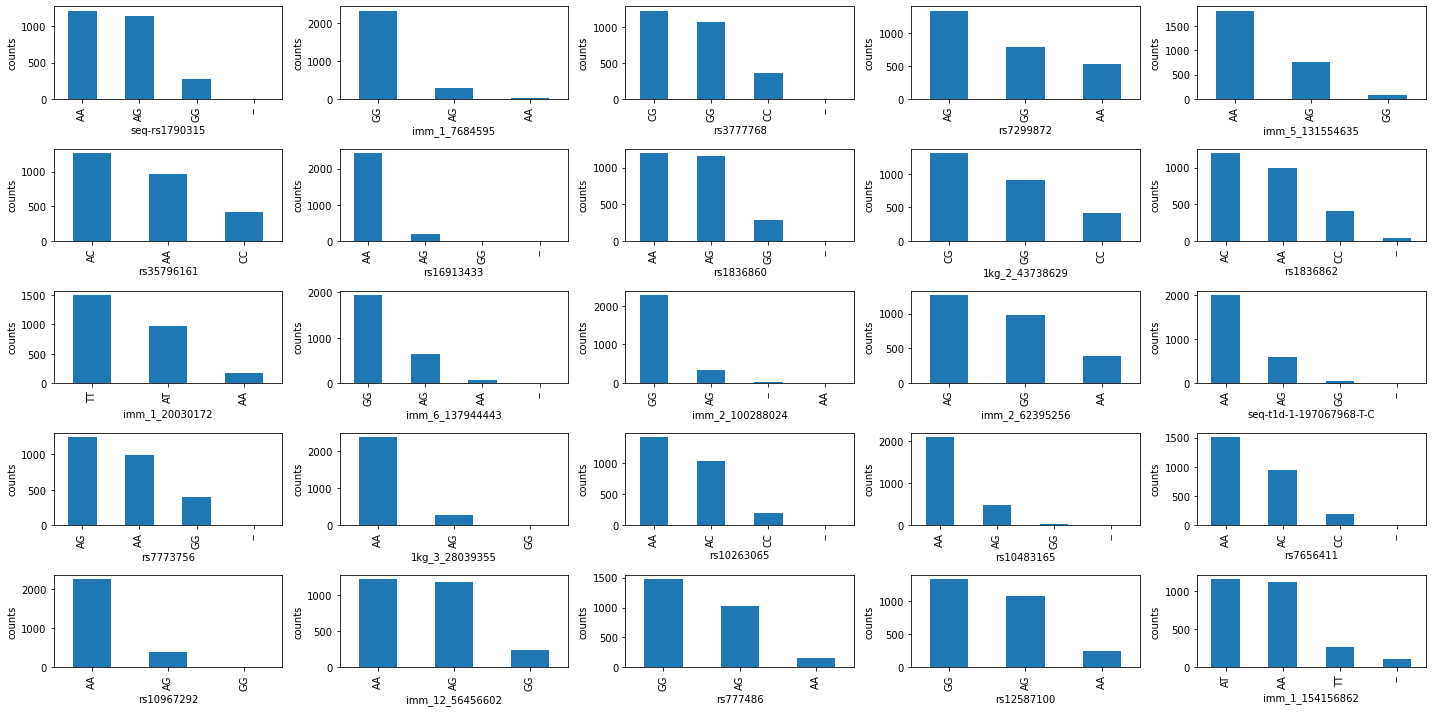

In [17]:
#Setup the subplots object
plt.subplots(5,5, figsize = (20,10))

#Create a counter
counter = 0

#loop over the first few columns in the data frame
for column in transpose_df.columns[0:25]:
    
    #increment counter
    counter+=1
    
    #plot the first subplot
    plt.subplot(5,5,counter)
    
    #label axes
    plt.xlabel(column)
    plt.ylabel("counts")
    
    #plot the value counts
    transpose_df[column].value_counts().plot(kind='bar')

#Cleanly display the figure
plt.tight_layout()

#Show the figure
plt.show()

**Observations:**
    
Now the distribution looks a lot more even. Most columns have 3 biallelic variants, whose frequency decreases monotonically. However, there are still a few left with missing values, so we will use some additional feature selection methods.

Step 7) Next we want to calculate p-values and keep only those SNPs that have strong associations with healthy or diseased patients. This will be determined by builiding a contingency table that looks something like this: 


|Allele|Healthy|Diseased|Totals|
|------|-------|--------|--------|
|A|3200|1800|**5000**|
|G|400|420|**820**|

and then performing chi-squared tests for each snp location to measure the strength of the association. A low p-value indicates that it is unlikely that the association between a single allele and the healthy or diseased class occurs due to random chance. Therefore that allele is likely predictive of healthy or diseased status.

In order to do this, we need to know which patient in the transpose_df is healthy and which patient has IBD. So let's look at the Patients file.

In [18]:
#Read in the patients data
patients= pd.read_csv("data\Combined_2645_Samples_Pedigree.csv")

#Set index as the individual id
patients = patients.set_index("Indiv_ID")

#View the dataframe
patients.head()

,Family_ID,Dad_ID,Mom_ID,Gender,Affectation,Disease
Indiv_ID,,,,,,
8370858003_R03C02,Fm8370858003_R03C02,0,0,1,2,CD
8370858003_R06C01,Fm8370858003_R06C01,0,0,1,2,CD
6298194052_R01C01,Fm6298194052_R01C01,0,0,2,2,CD
7384449023_R01C02,Fm7384449023_R01C02,0,0,1,2,CD
8370858003_R02C02,Fm8370858003_R02C02,0,0,2,2,CD


This dataframe has the following columns
Family_ID, Dad_ID, Mom_ID (representing family history)
    
Gender: Male / Female using the convention 1=male, 2=female

(see PED file format here https://gatk.broadinstitute.org/hc/en-us/articles/360035531972-PED-Pedigree-format)

Affectation: 1 = Healthy control, 2 = Diseased (CD / UC or IBD)
    
Disease: CD / UC / IBD / Control

Let's see how these are distributed.

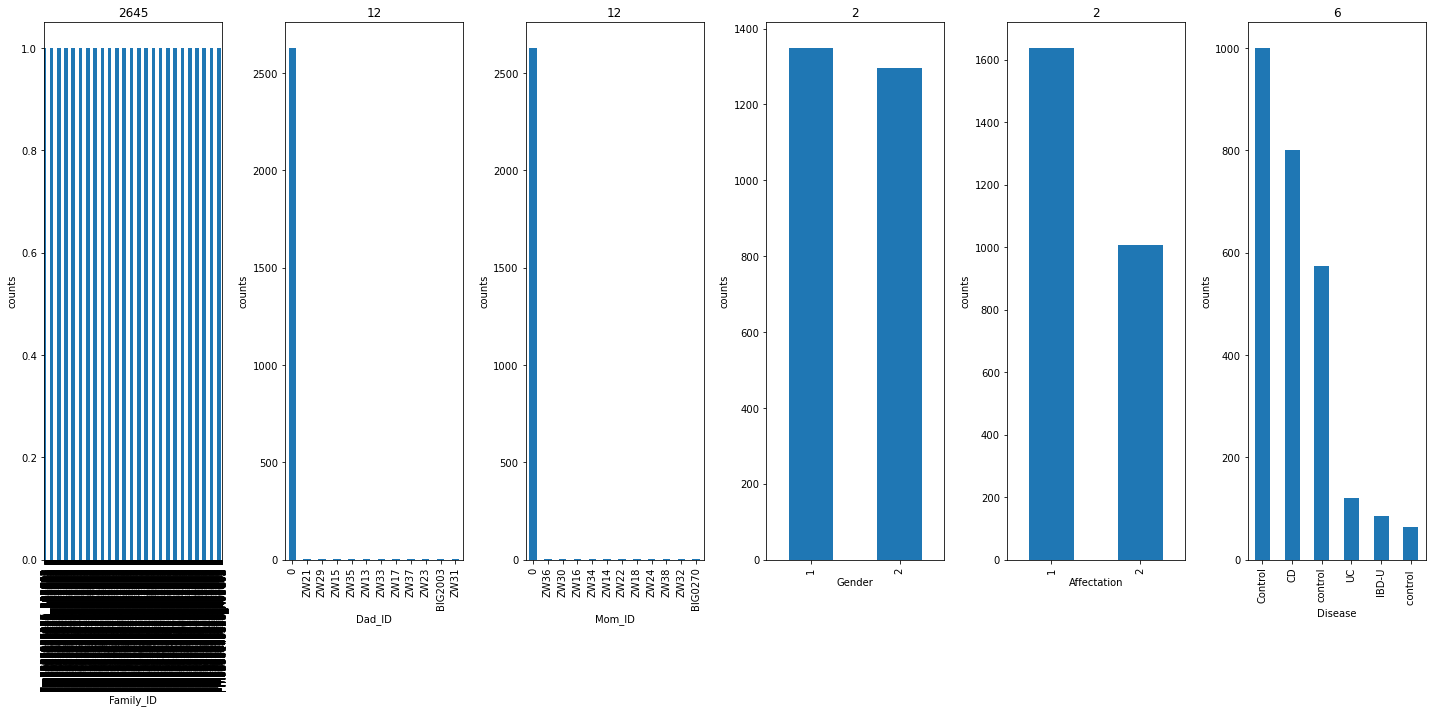

In [19]:
#Setup the subplots object
plt.subplots(1,6, figsize = (20,10))

#Create a counter
counter = 0

#loop over the first few columns in the data frame
for column in patients.columns:
    
    #increment counter
    counter+=1
    
    #plot the first subplot
    plt.subplot(1,6,counter)
    
    #label axes
    plt.xlabel(column)
    plt.ylabel("counts")
    plt.title(patients[column].nunique())
    
    #plot the value counts
    patients[column].value_counts().plot(kind='bar')

#Cleanly display the figure
plt.tight_layout()

#Show the figure
plt.show()

**Observations:**

Family_ID: There are 2645 unique values. So this seems to be unnecessary information.

Dad_ID: There are only 12 unique values, and most of these are 0, which means this information is missing for most individuals.

Mom_ID: There are only 12 unique values, and most of these are 0, which means this information is missing for most individuals.

Gender: There are only 2 unique values Male / Female using the convention 1=male, 2=female. There's an almost even balance of male and female.

Affectation: There are only 2 unique values 1 = Healthy control, 2 = Diseased (CD / UC or IBD). There is a slight imbalance here, with ~1600 healthy and ~1000 diseased samples.

Disease: There are 6 unique values, but many of them refer to the healthy control class and are just formatted differently. In reality there are only 4 classes. CD / UC / IBD / Control

For this project, I will only try to predict IBD / Non-IBD so we can roll up all the CD / UC / IBD cases into a single class. Since this information is already present in the `Affectation` column, we can get rid of the `Disease` column

In [20]:
#drop unnecessary columns
patients.drop(["Family_ID","Dad_ID", "Mom_ID", "Disease"], axis='columns', inplace = True)

#View the dataframe
patients.head()

,Gender,Affectation
Indiv_ID,,
8370858003_R03C02,1,2
8370858003_R06C01,1,2
6298194052_R01C01,2,2
7384449023_R01C02,1,2
8370858003_R02C02,2,2


I will be recoding Gender and Affectation as binary variables with new encoding:

||Old values|New Values|
|-----|----------|----------|
|Gender| `Male = 1`, `Female = 2`|`Male = 1`, `Female = 0`|
|Affectation| `Control = 1`, `Diseased = 2`|`Control = 0`, `Diseased = 1`|

In [21]:
#Recoding Gender and Affectation as binary encoded 0,1 variables
patients["Gender"] = np.where(patients["Gender"] == 2, 0, patients["Gender"])
patients["Affectation"] = np.where(patients["Affectation"] == 2, 1, 0)
patients.head()

,Gender,Affectation
Indiv_ID,,
8370858003_R03C02,1,1
8370858003_R06C01,1,1
6298194052_R01C01,0,1
7384449023_R01C02,1,1
8370858003_R02C02,0,1


and append this information to transpose_df so that we have a single dataframe

In [22]:
#Create a single dataframe
full_df = pd.concat([transpose_df, patients], axis=1, ignore_index=False)
full_df.head()

,seq-rs1790315,imm_1_7684595,rs3777768,rs7299872,imm_5_131554635,rs35796161,rs16913433,rs1836860,1kg_2_43738629,rs1836862,...,imm_9_138301427,imm_17_35321569,imm_1_196009571,rs13188874,rs17386441,imm_22_37997122,rs9541052,seq-rs1339131,Gender,Affectation
6198863118_R01C01,AA,GG,CG,AA,AA,AC,AA,AG,CG,AA,...,TT,AA,AG,AT,AA,GG,GG,GG,0,0
8647968039_R01C02,AA,GG,GG,AG,AA,CC,AA,AA,CG,AA,...,TT,AG,AA,AT,AA,GG,AG,GG,0,0
6198863118_R02C01,AG,GG,GG,GG,AA,AA,AA,GG,CG,AC,...,AT,AG,AA,TT,AA,GG,AG,GG,0,0
6198863118_R03C01,AA,GG,GG,AG,AA,AA,AA,GG,CC,AA,...,AT,GG,AA,TT,AG,GG,GG,GG,1,0
8647968039_R02C02,GG,GG,CG,AG,AA,AA,AA,AA,GG,AC,...,AT,AA,AA,TT,AA,GG,GG,AG,0,0


Separate the dataframes into healthy and diseased patients

In [23]:
healthy_df = full_df[full_df["Affectation"] == 0]
diseased_df = full_df[full_df["Affectation"] == 1]
print(healthy_df.shape)
print(diseased_df.shape)

(1637, 126684)
(1008, 126684)


We did all these manipulations because Step 7) Next we want calculate p-values and keep only those SNPs that have strong associations with healthy or diseased patients. So let's create two functions that create contigency tables that compare allele counts from healthy and diseased patients using a chi-squared test.

In [24]:
#Takes a single column as input
def create_healthy_counts_df(column):
    key_list, count_list = [], []
    
    #Create an empty string
    my_string = ""
    
    #Add all snp_pairs in that column into a single string
    for snp_pairs in healthy_df[column]:
        my_string = my_string + str(snp_pairs)

    #Use the Counter function to count the occurences of each character i.e. allele in the SNP column
    #The counts are returned as a dictionary that looks like this {"A": 3200, "G": 1452, "--":5}
    counts=Counter(my_string) 
    
    for key in counts.keys():
            #If the key is DNA letter 
            if key in ["A", "C", "G", "T"]:
                #then keep a count
                key_list.append(key), count_list.append(counts[key])
            #otherwise skip this 
            else:
                continue
                
    #return the contigency table as a dataframe
    blah = pd.DataFrame([key_list, count_list]).T.set_index(0)
    blah.columns = ["healthy"]
    return blah

In [25]:
#Takes a single column as input
def create_diseased_counts_df(column):
    key_list, count_list = [], []
    
    #Create an empty string
    my_string = ""
    
    #Add all snp_pairs into a single string
    for snp_pairs in diseased_df[column]:
        my_string = my_string + str(snp_pairs)

    #Use the Counter function to count the occurences of each character i.e. allele in the SNP column
    #The counts are returned as a dictionary that looks like this {"A": 3200, "G": 1452, "--":5}
    counts=Counter(my_string) 
    
    for key in counts.keys():
            #If the key is DNA letter 
            if key in ["A", "C", "G", "T"]:
                #then keep a count
                key_list.append(key), count_list.append(counts[key])
            #otherwise skip this
            else:
                continue
                
    #return the contigency table as a dataframe
    blah = pd.DataFrame([key_list, count_list]).T.set_index(0)
    blah.columns = ["diseased"]
    return blah

Then run chi-squared tests for each snp location which outputs a p-value for each association.

In [26]:
from scipy.stats import chi2_contingency

p_values_list, columns_list = [], []
counter = 0

#loop over all the columns in the full_df except the last 2
for my_columns in tqdm(full_df.columns[:-2]):
    
    #Get healthy counts and store them in a dataframe
    my_df = create_healthy_counts_df(my_columns)
    
    #Get diseased counts
    my_df2 = create_diseased_counts_df(my_columns)
    
    #create concat_df to create a contingency table
    concat_df = pd.concat([my_df, my_df2], axis = 1)
    
    #Sometimes we will get NA values, since we are ignoring missing values in the create_healthy_counts_df and the create_diseased_counts_df functions
    #These missing values need to be handled in cases where missing values are the second most common alleles in concat_df.
    #By replacing NA values with a 1 we avoid getting weird results when we perform the chi-squared tests later
    concat_df.fillna(1)
    
    #add name to columns_list
    columns_list.append(my_columns)
    
    #Calculate chi-squared test p-values
    stat, p, dof, expected = chi2_contingency(concat_df)
    p_values_list.append(p)
        
#Create a single df with all the p-values        
pval_df = pd.DataFrame(p_values_list, columns = ["p_values"])
print(pval_df.shape)

100%|█████████████████████████████████████████████████████████████████████████| 126682/126682 [14:23<00:00, 146.69it/s]


(126682, 1)


Step 7) Applying a p-value cut-off (default is < 1e-7)

**While all the other steps are mandatory, this step is unique since this is tunable. The default threshold is 1e-7, but we can increase or decrease this threshold to retain more or less features.**

In [27]:
#collect the indices of the columns we want to keep 
indices_to_keep = pval_df[pval_df["p_values"] < 1e-7].index
print(len(indices_to_keep))

413


That was a massive change! We went from having 126682 columns to just 413 SNP columns that have a strong association with either the healthy or diseased class. We can see how this number would change if we increased or decreased our p-value cut-off

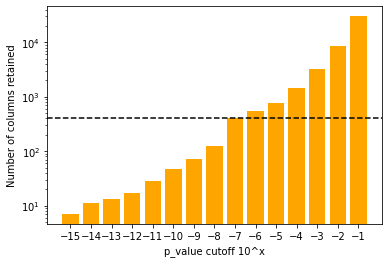

In [28]:
#Set the range
p_val_range = np.arange(-15,0,1)

#Create empty list
cols_to_keep = []

#loop over range
for i in p_val_range:
    
    #Keep those indexes where p_value is less than the value specified by 10.0**i
    idx_to_keep = pval_df[pval_df["p_values"] < 10.0**i].index
    
    #append length of idx_to_keep object to cols_to_keep list 
    cols_to_keep.append(len(idx_to_keep))
    
#Plot Number of columns retained vs p_value cutoff
plt.figure()  
plt.bar(p_val_range, cols_to_keep, log=True, color='orange')
plt.xticks(p_val_range)
plt.axhline(413, linestyle = "--", c="black")
plt.xlabel("p_value cutoff 10^x")
plt.ylabel("Number of columns retained")
plt.show()

The trend is clear. **lower p-value cut-off = higher stringency = less features retained**. 
The 10^-7 cutoff was chosen for a couple of reasons. 

1) It keeps the number of features low (only 413), which helps with run-time for downstream model fitting steps.

2) Since we ran > 100,000 chi-squared tests earlier, we need to account for the fact that we're running so many tests. If we use the Bonferroni correction

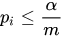

then our p_value threshold becomes 0.05 / 100,000 = 5e-7. In order to keep this more stringent I picked 1e-7.

In [29]:
#Using the indices figure out which columns need to be kept from the full_df
columns_to_keep = full_df.columns[indices_to_keep]

Now we store the filtered p-values in a new dataframe called clean_df

In [30]:
#Create a clean df with these features
clean_df = full_df[columns_to_keep]
clean_df.shape

(2645, 413)

In [31]:
#Attach the gender and the affectation information to clean_df
clean_df = pd.concat([clean_df, patients], axis=1, ignore_index=False)
clean_df.head()

,rs3769005,imm_1_67459652,imm_7_51057559,rs2959751,imm_3_49619016,imm_16_49296951,imm_3_49522565,rs2534123,rs3100566,rs2254400,...,imm_10_101280291,rs2552595,imm_5_158466251,rs1375132,rs1375131,rs2563397,1kg_1_241045805,rs34367277,Gender,Affectation
6198863118_R01C01,GG,AG,AG,AA,GG,GG,AA,GG,GG,AA,...,AA,AA,GG,AA,AA,GG,AA,GG,0,0
8647968039_R01C02,GG,AG,GG,AA,AG,AG,AG,GG,GG,AA,...,GG,AA,GG,AA,AA,GG,AA,GG,0,0
6198863118_R02C01,GG,AA,GG,AA,AG,GG,AG,GG,GG,AA,...,AA,AA,GG,AA,AA,GG,AA,GG,0,0
6198863118_R03C01,CG,GG,AG,AG,AG,AG,AG,AG,AG,AG,...,AG,AG,GG,AG,GG,AG,AG,AG,1,0
8647968039_R02C02,GG,AA,GG,AA,GG,AG,AA,GG,GG,AA,...,AG,AA,GG,AA,AA,GG,AA,GG,0,0


**Manhattan plot**

In order to visualize the retained SNPs vs the discarded SNPs we will use a Manhattan plot. The following tutorial was very helpful while building this plot https://www.youtube.com/watch?v=Ej4FkgLOvQ0&ab_channel=PythonforBiologists

In [32]:
#Create a new dataframe with snps and p_values 
some_df = pd.concat([pd.Series(columns_list), pval_df], axis= 'columns')

#rename columns to have appropriate names
some_df.columns = ["snp", "p_values"]

some_df.head()

,snp,p_values
0,seq-rs1790315,0.214077
1,imm_1_7684595,0.082743
2,rs3777768,0.305179
3,rs7299872,0.076392
4,imm_5_131554635,0.860756


In [33]:
#Create another dataframe that also contains the chr and position information from the genotypes dataframe by performing a left join
plot_portion = pd.merge(some_df, genotypes.iloc[:,0:3], on="snp", how = 'left')

#add a column by calculating -logP
plot_portion["-10logP"] = -np.log10(plot_portion["p_values"])

#Convert the chr column to type string
plot_portion["chr"] = plot_portion["chr"].astype(str)

plot_portion

,snp,p_values,chr,pos,-10logP
0,seq-rs1790315,0.214077,11,70780791,0.669430
1,imm_1_7684595,0.082743,1,7684595,1.082267
2,rs3777768,0.305179,6,12255600,0.515446
3,rs7299872,0.076392,12,55233823,1.116954
4,imm_5_131554635,0.860756,5,131554635,0.065120
...,...,...,...,...,...
126677,rs13188874,0.352314,5,129698191,0.453070
126678,rs17386441,0.818444,1,98818587,0.087011
126679,imm_22_37997122,0.803290,22,37997122,0.095128
126680,rs9541052,0.277689,13,67855709,0.556442


In [34]:
plot_portion["chr"].unique()

array(['11', '1', '6', '12', '5', '3', '2', '7', '22', '4', '9', '14',
       'XY', '8', '17', '10', '21', '16', '19', '13', '18', '15', 'X',
       '20', 'Y'], dtype=object)

We want to sort the dataframe plot_portion using the `chr` column for plotting. 

However, when sorting this list alphabetically ascending, we end up sorting in the order 

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',

'2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9',

'X','XY', 'Y']

which is not quite what we want. So we will do some wrangling to sort the dataframe correctly.

In [35]:
#First separate the numerical chromosomes from the non-numerical chromosomes

#Non-numeric
list1 = ["X", "Y", "XY"]
#Numeric
list2 = list(plot_portion[~plot_portion["chr"].isin(list1)]["chr"].unique())

#Sort the numbers using the key parameter inside the sort function which first converts to int before sorting
list2.sort(key=int)

#Then add the two lists together
list2 = list2 + list1

print(list2)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'XY']


This ordering looks more like what we need. In order to sort the dataframe with this custom ordering, we will first create a new dictionary with the ordered elements from list2 as `keys` and integers from 1 - 15 as `values`.

In [36]:
numbers_list = np.arange(1,26)

#create a new dictionary with the ordered elements from list2 as keys and integers from 1 - 15 as values
my_dict = dict(zip(list2, numbers_list))

#view my_dict
print(my_dict)

{'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, 'X': 23, 'Y': 24, 'XY': 25}


then we will sort using this custom order by using a lambda function

In [37]:
#sort values first by "chr" using custom ordering, which is accomplished by key=lambda x: x.map(my_dict)
#the second sort is by "pos"
#then we only retain 4 columns ["snp", "chr", "pos", "-10logP"]
plot_portion = plot_portion.sort_values(by=['chr', "pos"], key=lambda x: x.map(my_dict))[["snp", "chr", "pos", "-10logP"]]
plot_portion

,snp,chr,pos,-10logP
1,imm_1_7684595,1,7684595,1.082267
10,imm_1_20030172,1,20030172,0.650885
14,seq-t1d-1-197067968-T-C,1,197067968,0.180983
24,imm_1_154156862,1,154156862,3.189491
27,imm_1_181823018,1,181823018,0.107248
...,...,...,...,...
126498,rs1700954,XY,2618135,0.558174
126565,rs2563397,XY,91022440,7.280999
126585,rs5950746,XY,424354,0.162397
126603,rs7055552,XY,1412072,0.317737


Now that we've sorted the dataframe the correct way, we will add a column called cum_pos which keeps a running count of the position. This will later be used as the X-axis of our Manhattan plot.

In [38]:
running_pos = 0
cumulative_pos = []

#loop through each chromosome in the plot_portion.groupby("chr") object, and for each chromosme find the max position for that chromosome.
#Once the max is found, add it to the values in the "pos" columns. The effect of this is that the chromosomes getting ordered in a line.
#first you line up all the positions in chromosome 1 followed by all the positions in chromosome 2 followed by chromosome 3 etc...
for chromosome, group_df in plot_portion.groupby("chr"):
    cumulative_pos.append(group_df["pos"] + running_pos)
    running_pos += group_df["pos"].max()
    
#Add a column to plot_portion that has all the cumulative positions. 
plot_portion["cum_pos"] = pd.concat(cumulative_pos)
plot_portion

,snp,chr,pos,-10logP,cum_pos
1,imm_1_7684595,1,7684595,1.082267,7684595
10,imm_1_20030172,1,20030172,0.650885,20030172
14,seq-t1d-1-197067968-T-C,1,197067968,0.180983,197067968
24,imm_1_154156862,1,154156862,3.189491,154156862
27,imm_1_181823018,1,181823018,0.107248,181823018
...,...,...,...,...,...
126498,rs1700954,XY,2618135,0.558174,3038056103
126565,rs2563397,XY,91022440,7.280999,3126460408
126585,rs5950746,XY,424354,0.162397,3035862322
126603,rs7055552,XY,1412072,0.317737,3036850040


Lastly, we define a colorgroup where all the values that are >7 in the "-10logP" columns are labelled with A, otherwise labelled with B. We use this column later to color points in the Manhattan plot.

In [39]:
plot_portion["colorgroup"] = np.where(plot_portion["-10logP"] > 7, "A", "B")
plot_portion

,snp,chr,pos,-10logP,cum_pos,colorgroup
1,imm_1_7684595,1,7684595,1.082267,7684595,B
10,imm_1_20030172,1,20030172,0.650885,20030172,B
14,seq-t1d-1-197067968-T-C,1,197067968,0.180983,197067968,B
24,imm_1_154156862,1,154156862,3.189491,154156862,B
27,imm_1_181823018,1,181823018,0.107248,181823018,B
...,...,...,...,...,...,...
126498,rs1700954,XY,2618135,0.558174,3038056103,B
126565,rs2563397,XY,91022440,7.280999,3126460408,A
126585,rs5950746,XY,424354,0.162397,3035862322,B
126603,rs7055552,XY,1412072,0.317737,3036850040,B


Finally we are ready to build the Manhattan plot!

<Figure size 432x288 with 0 Axes>

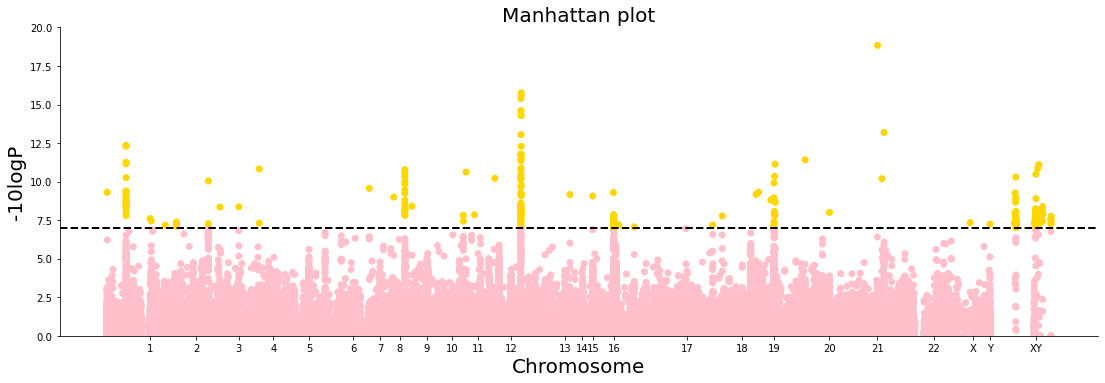

In [40]:
#Set up the figure object
plt.figure()

#sns.relplot builds a scatter plot in seaborn. by setting g = sns.relplot, we can then access various elements of the plot using syntax like
#g.ax.set_xlabel("Chromosome"), which changes the x-axis label
g = sns.relplot(data = plot_portion, #Data is the dataframe
            x = "cum_pos", #X-axis
            y = "-10logP", #Y-axis
            hue = "colorgroup", #Set colors of points using the colorgroups we defined earlier
            palette = ["pink","gold"], #color the groups A and B with gold and pink respectively
            aspect = 3, #This setting makes the plot 3x as wide as it is tall
            s=50, #sets dot size to 50
            linewidth = 0, #removes outlines of the dots
            legend = None) #no legend

#re-label x and y-axis
g.ax.set_xlabel("Chromosome", fontsize = 20) 
g.ax.set_ylabel("-10logP", fontsize = 20) 


#define where we want the x labels to go. We align the labels correctly by placing each label at the median value of that chromosome,
#which places the label at the center of the region that each chromosome occupies 
x_label_locations = plot_portion.groupby(["chr"]).median()["cum_pos"]
g.ax.set_xticks(x_label_locations)

#Set labels equal to the name of the chromosome
g.ax.set_xticklabels(plot_portion["chr"].unique())

#draw a horizontal line at the cut-off point
plt.axhline(7, linestyle = '--', c='black', linewidth = 2)

#set y axis limits to scale the plots correctly
plt.ylim(0,20)

plt.title("Manhattan plot", fontsize = 20)
#show the plot
plt.show()

and there it is! A beautiful Manhattan plot! The gold dots represent SNPs that were retained after all the filtering, while pink dots were not retained.

Let us check agains how the distribution of SNPs has changed after all these cleaning steps

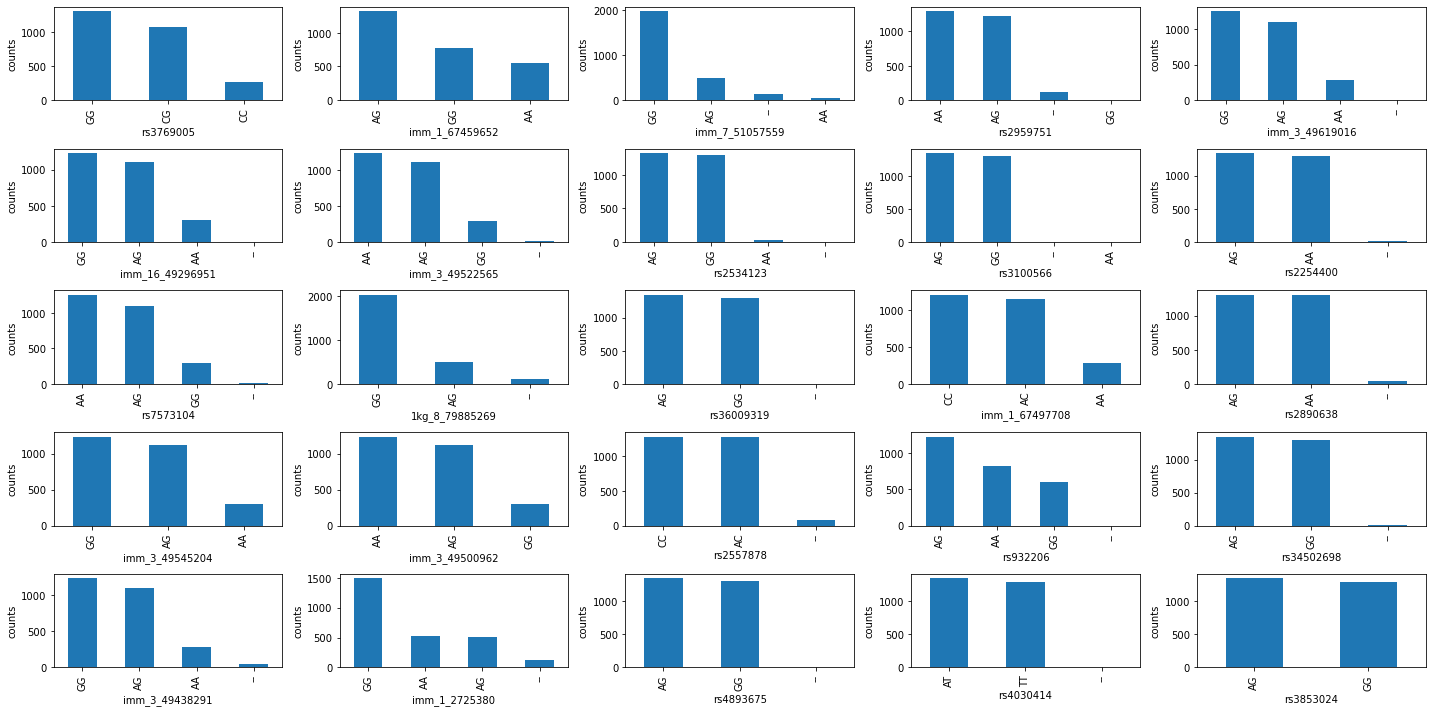

In [41]:
#Setup the subplots object
plt.subplots(5,5, figsize = (20,10))

#Create a counter
counter = 0

#loop over the first few columns in the data frame
for column in clean_df.columns[0:25]:
    
    #increment counter
    counter+=1
    
    #plot the first subplot
    plt.subplot(5,5,counter)
    
    #label axes
    plt.xlabel(column)
    plt.ylabel("counts")
    
    #plot the value counts
    clean_df[column].value_counts().plot(kind='bar')

#Cleanly display the figure
plt.tight_layout()

#Show the figure
plt.show()

**Observations:**
    
Now the distribution looks a lot more even. Most columns have 2-3 biallelic variants, whose frequency decreases monotonically. However, there are still a few left with missing values.

For model fitting we need to convert the genomic labels that are letters, `A,C,G,T` into numbers. We will do this using One-Hot encoding.

In [42]:
#Use the get_dummies method for one hot encoding
dummies_df = pd.get_dummies(clean_df)
dummies_df.head()

,Gender,Affectation,rs3769005_CC,rs3769005_CG,rs3769005_GG,imm_1_67459652_AA,imm_1_67459652_AG,imm_1_67459652_GG,imm_7_51057559_--,imm_7_51057559_AA,...,rs1375131_AG,rs1375131_GG,rs2563397_AG,rs2563397_GG,1kg_1_241045805_--,1kg_1_241045805_AA,1kg_1_241045805_AG,rs34367277_--,rs34367277_AG,rs34367277_GG
6198863118_R01C01,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
8647968039_R01C02,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
6198863118_R02C01,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
6198863118_R03C01,1,0,0,1,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,1,0
8647968039_R02C02,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1


Let's put the "Affectation" column at the end of the dataframe

In [43]:
#pops out the "affectation" column and saves it as a new dataframe
affectation_df = dummies_df.pop("Affectation")

#add back the column at the end
dummies_df["Affectation"] = affectation_df

#View
dummies_df.head()

,Gender,rs3769005_CC,rs3769005_CG,rs3769005_GG,imm_1_67459652_AA,imm_1_67459652_AG,imm_1_67459652_GG,imm_7_51057559_--,imm_7_51057559_AA,imm_7_51057559_AG,...,rs1375131_GG,rs2563397_AG,rs2563397_GG,1kg_1_241045805_--,1kg_1_241045805_AA,1kg_1_241045805_AG,rs34367277_--,rs34367277_AG,rs34367277_GG,Affectation
6198863118_R01C01,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
8647968039_R01C02,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
6198863118_R02C01,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
6198863118_R03C01,1,0,1,0,0,0,1,0,0,1,...,1,1,0,0,0,1,0,1,0,0
8647968039_R02C02,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


Step 8) As a last step, we want to drop all columns that contain one hot encoded values corresponding to  `"--"`, since they don't carry meaningful biological information

In [44]:
#Collect all the column names
dummies_cols = pd.Series(dummies_df.columns)

#Create a new dataframe with those column names
no_dashes_df = pd.DataFrame(dummies_cols)

#Split the column on the "_" character from the right and save the split column names into 2 new columns
no_dashes_df[["1","2"]] = no_dashes_df[0].str.rsplit(pat = "_", n=1, expand = True)
no_dashes_df

,0,1,2
0,Gender,Gender,None
1,rs3769005_CC,rs3769005,CC
2,rs3769005_CG,rs3769005,CG
3,rs3769005_GG,rs3769005,GG
4,imm_1_67459652_AA,imm_1_67459652,AA
...,...,...,...
1397,1kg_1_241045805_AG,1kg_1_241045805,AG
1398,rs34367277_--,rs34367277,--
1399,rs34367277_AG,rs34367277,AG
1400,rs34367277_GG,rs34367277,GG


In [45]:
#drop the rows that have dashes in the name
drop_dashes_columns = no_dashes_df[no_dashes_df["2"]== "--"][0]
drop_dashes_columns

7        imm_7_51057559_--
11            rs2959751_--
15       imm_3_49619016_--
19      imm_16_49296951_--
23       imm_3_49522565_--
               ...        
1379          rs2552595_--
1382    imm_5_158466251_--
1389          rs1375131_--
1395    1kg_1_241045805_--
1398         rs34367277_--
Name: 0, Length: 344, dtype: object

In [46]:
#Then drop those columns from dummies_df
dummies_df.drop(drop_dashes_columns, inplace = True, axis = 'columns')
dummies_df.head()

,Gender,rs3769005_CC,rs3769005_CG,rs3769005_GG,imm_1_67459652_AA,imm_1_67459652_AG,imm_1_67459652_GG,imm_7_51057559_AA,imm_7_51057559_AG,imm_7_51057559_GG,...,rs1375131_AA,rs1375131_AG,rs1375131_GG,rs2563397_AG,rs2563397_GG,1kg_1_241045805_AA,1kg_1_241045805_AG,rs34367277_AG,rs34367277_GG,Affectation
6198863118_R01C01,0,0,0,1,0,1,0,0,1,0,...,1,0,0,0,1,1,0,0,1,0
8647968039_R01C02,0,0,0,1,0,1,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
6198863118_R02C01,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
6198863118_R03C01,1,0,1,0,0,0,1,0,1,0,...,0,0,1,1,0,0,1,1,0,0
8647968039_R02C02,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0


Voila! Our cleaning process is complete! We now have a dataframe that can be used for modeling. Let's save this dataframe to file so we can use it later.

In [47]:
dummies_df.to_csv("GWAS_analysis_OHE.csv", index=True)